Задание
Вопросы по заданию
В этом разделе можно задать вопросы и получить ответ.
Преподаватель: Даниил Корбут, Наталья Баданина, Александр Миленькин, Анастасия Успенская
Задание к домашней работе
1.	Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)
2.	Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3.	Построить случайный лес, вывести важность признаков
4.	Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5.	Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6.	Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7.	В качестве решения: Jupyter notebook с кодом, комментариями и графиками


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from jupyterthemes import jtplot

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline
jtplot.style()

In [2]:
RANDOM_STATE = 42
N_FOLDS = 12

data = pd.read_csv('train3.csv')
                   
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Разбиваем на train/test
d_train, d_test, y_train, y_test = train_test_split(data.drop('SalePrice',axis=1),
                                                    data.SalePrice, random_state=RANDOM_STATE, test_size=0.2)
d_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [5]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

# Фильтровать не приходится, т.к. максимальное количество значений - 25
#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
# cat_feat = list(cat_nunique[cat_nunique < 30].index)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        4
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [6]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [7]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior1st_BrkFace,SaleType_WD,SaleCondition_Alloca,Condition2_Feedr,Neighborhood_ClearCr,Exterior2nd_AsbShng,LandSlope_Mod,Neighborhood_Crawfor,HouseStyle_2Story,FireplaceQu_Fa
254,20,70.0,8400,5,6,1957,1957,0.0,922,0,...,0,1,0,0,0,0,0,0,0,0
1066,60,59.0,7837,6,7,1993,1994,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
638,30,67.0,8777,5,7,1910,1950,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
799,50,60.0,7200,5,7,1937,1950,252.0,569,0,...,0,1,0,0,0,0,0,0,0,0
380,50,50.0,5000,5,6,1924,1950,0.0,218,0,...,1,1,0,0,0,0,0,0,0,0


Случайный лес

Важные гиперпараметры алгоритма

a. Параметры деревьев

criterion - критерий построения дерева
max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)
b. Параметры леса

n_estimators - кол-во деревьев (чем больше тем лучше)
max_features - число признаков случайного подпространства
n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

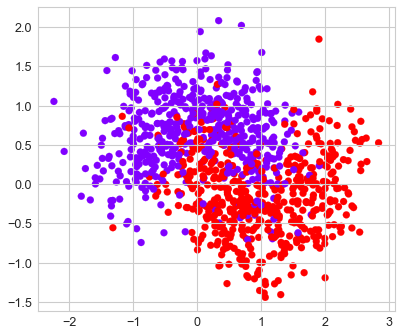

In [8]:
from sklearn.datasets import make_moons
mX, my = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.3)

plt.scatter(mX[:, 0], mX[:, 1], c=my, s=50, cmap='rainbow')
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
parameters = {
    'n_estimators':[10, 20 ],
    'max_depth': list(range(2, 5)),
    'min_samples_leaf': [3, 5],
    'min_samples_split': list(range(2, 10))
}

In [12]:
tree_grid = GridSearchCV(RandomForestRegressor(), parameters, cv = 7, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 20]})

In [13]:
print(tree_grid.best_params_)

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 20}


In [14]:
best_tree = tree_grid.best_estimator_

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
y_pred_rf_best = best_tree.predict(X_test)
print('Random forest best regressor metrics: ')
print(f'Score: {best_tree.score(X_test, y_test)}')
print(f'R2: {r2_score(y_pred_rf_best, y_test)}')

Random forest best regressor metrics: 
Score: 0.816897958056476
R2: 0.6970281458326761


In [17]:
cross_val_rf_mean = np.mean(cross_val_score(best_tree, X_test, y_test, cv = 10, scoring = 'r2' ))
cross_val_rf_mean

0.7874393644994109

Обучить стекинг как минимум 3х моделей, используя хотя бы 1 линейную модель и 1 нелинейную

In [18]:
# подготовим признаки для обучения 
# Разбиваем на train/test

X = data[data.columns[data.columns!='SalePrice']]   
y = data['SalePrice']

Ds_train, Ds_test, ys_train, ys_test = train_test_split(X, y, test_size=0.3, random_state=39)

In [19]:
# Создаем дамми-переменные для категорий
dummy_s_train = pd.get_dummies(Ds_train[cat_feat], columns=cat_feat)  # преобразовываем категориальную переменную 
dummy_s_test = pd.get_dummies(Ds_test[cat_feat], columns=cat_feat)    # в фиктивные / индикаторные переменные

dummy_s_cols = list(set(dummy_s_train) & set(dummy_s_test))           # список уникальных (set) колонок категориальных признаков

dummy_s_train_q = dummy_s_train[dummy_s_cols]                         # обучающийся сет категориальных признаков 
dummy_s_test_q = dummy_s_test[dummy_s_cols]                           # тестовый сет категориальных признаков]                           # тестовый сет категориальных признаков

In [20]:
# для обучаемого сета находим медианное значение
train_median = Ds_train[num_feat].median()   

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Определяем переменную Х через конкатенацию признаков с обработанными значениями NaN
Xs_train = pd.concat([Ds_train[num_feat].fillna(train_median),      # обрабатываем пустые значения, если таковые имеются
                     Ds_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_s_train_q], axis=1)

Xs_test = pd.concat([Ds_test[num_feat].fillna(train_median),
                     Ds_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_s_test_q], axis=1)


In [22]:
# Стандартиззируем выборку численных признаков путем удаления среднего и масштабирования до единичной дисперсии
scaler = StandardScaler()
scaler.fit(Xs_train[num_feat])

Xs_train[num_feat] = scaler.transform(Xs_train[num_feat])
Xs_test[num_feat] = scaler.transform(Xs_test[num_feat])

# Xs_train.shape, ys_train.shape

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor

# Займемся непосредственым обученем стекинга 
# Финальное решение в стеке обучающихся моделей принимает логистическая регрессия  

regr = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('rfr', RandomForestRegressor(random_state=44)),
        ('knr', KNeighborsRegressor())
    ],
LinearRegression(), cv=10)


In [24]:
regr.fit(Xs_train, ys_train)
y_pred_stack = regr.predict(Xs_test)
print('Stacking metrics: ')
print(f'Score: {regr.score(Xs_test, ys_test)}')
print(f'R2: {r2_score(y_pred_stack, ys_test)}')

Stacking metrics: 
Score: 0.8502218427319188
R2: 0.845172364388761


Так же применим кросс-валидацию и здесь.

In [25]:
cross_val_stack_mean = np.mean(cross_val_score(regr, Xs_train, ys_train, cv = 10, scoring = 'r2' ))
cross_val_stack_mean

0.8440228482599258